Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [74]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [75]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [76]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Test')

In [77]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset


train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=123,  image_size=(180, 180), batch_size=batch_size,shuffle=True,validation_split=0.2, subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    image_size=(180, 180),
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    subset='validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

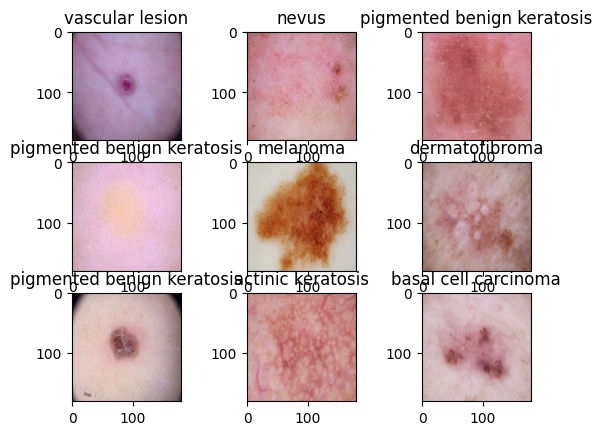

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
import tensorflow as tf
from tensorflow.keras import layers

# Define the CNN model
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # Assuming 9 classes
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [16]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Train the model

In [17]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
56/56 [==============================] - 221s 924ms/step - loss: 1.9406 - accuracy: 0.2790 - val_loss: 1.6964 - val_accuracy: 0.4430
Epoch 2/10
56/56 [==============================] - 2s 34ms/step - loss: 1.6337 - accuracy: 0.4174 - val_loss: 1.5954 - val_accuracy: 0.3982
Epoch 3/10
56/56 [==============================] - 2s 34ms/step - loss: 1.4921 - accuracy: 0.4570 - val_loss: 1.4858 - val_accuracy: 0.4832
Epoch 4/10
56/56 [==============================] - 2s 35ms/step - loss: 1.3817 - accuracy: 0.5246 - val_loss: 1.3521 - val_accuracy: 0.5324
Epoch 5/10
56/56 [==============================] - 2s 35ms/step - loss: 1.2840 - accuracy: 0.5402 - val_loss: 1.4895 - val_accuracy: 0.4676
Epoch 6/10
56/56 [==============================] - 2s 36ms/step - loss: 1.2484 - accuracy: 0.5558 - val_loss: 1.3757 - val_accuracy: 0.5302
Epoch 7/10
56/56 [==============================] - 2s 34ms/step - loss: 1.1863 - accuracy: 0.5714 - val_loss: 1.5083 - val_accuracy: 0.4653
Epoch 8/10

### Visualizing training results

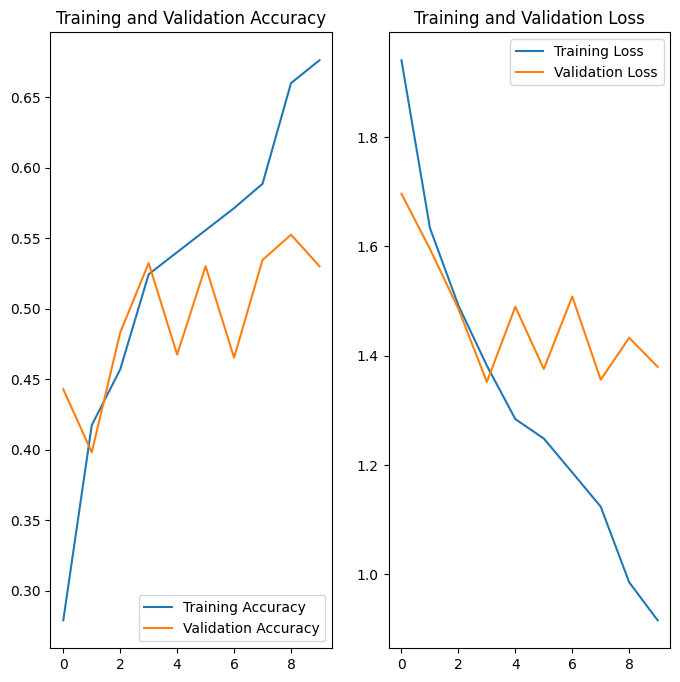

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

The training accuracy is approximately 66%
The validation accuracy is around 61%

so it seems that this is neither amn overfitting case nor an underfitting


In [19]:
class_to_label = {class_name: label for label, class_name in enumerate(class_names)}

# Now assign integer labels to your training data
train_labels = [class_to_label[class_name] for class_name in class_names]



In [20]:
train_labels = train_ds.map(lambda image, label: label)

for images, labels in train_ds.take(1):
    # Print the shape of image tensors and labels
    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)

Image shape: (32, 180, 180, 3)
Label shape: (32,)


In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define your data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.8, 1.2)
)

# Convert TensorFlow Dataset to NumPy arrays
# Assuming 'train_ds' yields (image, label) tuples
train_images = []
train_labels_array = []
for images, labels in train_ds:
    train_images.append(images.numpy())  # Convert image tensors to NumPy arrays
    train_labels_array.append(labels.numpy())

train_images = np.concatenate(train_images, axis=0)  # Stack images into a single array
train_labels_array = np.concatenate(train_labels_array, axis=0)

# Apply data augmentation to training data
train_generator = datagen.flow(
    x=train_images,  # NumPy array of images
    y=train_labels_array,  # NumPy array of labels
    batch_size=32,
    shuffle=True
)


In [22]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here






### Todo:
### Create the model, compile and train the model


In [23]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add a Dropout layer
model.add(Dense(10, activation='softmax'))  # Adjust num_classes based on your task

### Compiling the model

In [24]:
## Your code goes here
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
import numpy as np

train_images_list = []
train_labels_list = []
for train_batch in train_ds:
    train_images, train_labels = train_batch
    train_images_list.append(train_images.numpy())  # Convert EagerTensors to NumPy arrays
    train_labels_list.append(train_labels.numpy())

# Concatenate the list of arrays into a single NumPy array
train_images = np.concatenate(train_images_list, axis=0)
train_labels = np.concatenate(train_labels_list, axis=0)

import tensorflow as tf
train_images = tf.convert_to_tensor(train_images)
# One-hot encode the labels
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10) # Assuming 10 classes

# Now train the model with NumPy arrays for both inputs

# Now train the model with NumPy arrays for both inputs


### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs

def create_and_train_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(180, 180, 3)),  # Adjust input shape to match training data
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Split the training data into training and validation sets
    # For example, using 80% for training and 20% for validation
    split_index = int(0.8 * len(train_images))
    train_images_train = train_images[:split_index]
    train_labels_train = train_labels[:split_index]
    train_images_val = train_images[split_index:]
    train_labels_val = train_labels[split_index:]

    # Train the model with validation data
    history = model.fit(train_images_train, train_labels_train,
                        epochs=20,
                        validation_data=(train_images_val, train_labels_val))
    return history

# Call the function to create and train your model
history = create_and_train_model()

Epoch 1/20
45/45 [==============================] - 3s 29ms/step - loss: 12284.9570 - accuracy: 0.1396 - val_loss: 5177.3726 - val_accuracy: 0.2674
Epoch 2/20
45/45 [==============================] - 1s 16ms/step - loss: 4723.9619 - accuracy: 0.2156 - val_loss: 4755.9814 - val_accuracy: 0.1253
Epoch 3/20
45/45 [==============================] - 1s 14ms/step - loss: 4995.2544 - accuracy: 0.2366 - val_loss: 3504.5933 - val_accuracy: 0.2423
Epoch 4/20
45/45 [==============================] - 1s 14ms/step - loss: 3997.8171 - accuracy: 0.2303 - val_loss: 4268.5454 - val_accuracy: 0.2535
Epoch 5/20
45/45 [==============================] - 1s 14ms/step - loss: 3813.9490 - accuracy: 0.2659 - val_loss: 3521.5425 - val_accuracy: 0.4123
Epoch 6/20
45/45 [==============================] - 1s 14ms/step - loss: 3399.1863 - accuracy: 0.2819 - val_loss: 2287.9373 - val_accuracy: 0.2228
Epoch 7/20
45/45 [==============================] - 1s 15ms/step - loss: 3059.3406 - accuracy: 0.2680 - val_loss: 231

### Visualizing the results

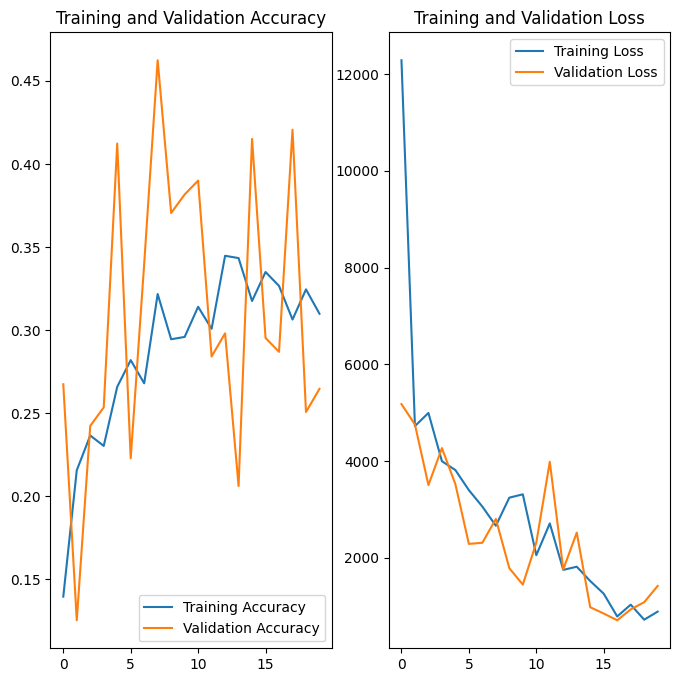

In [29]:


# Get the number of epochs from the training history
num_epochs = len(history.history['loss'])
epochs_range = range(num_epochs)

# Extract training and validation metrics from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [30]:
## Your code goes here.

import collections

# Assuming you have 'train_labels' as your integer labels (class IDs)
def get_class_distribution(labels):
    class_distribution = collections.Counter(labels)
    return class_distribution

# Example usage:
train_labels = [0, 1, 2, 0, 3, 1, 4, 2, 5, 6,7,8,9]  # Replace with your actual labels
train_ds_class_dist = get_class_distribution(train_labels)

# Print the class distribution
for label, count in train_ds_class_dist.items():
    print(f"Class {label}: {count} instances")

Class 0: 2 instances
Class 1: 2 instances
Class 2: 2 instances
Class 3: 1 instances
Class 4: 1 instances
Class 5: 1 instances
Class 6: 1 instances
Class 7: 1 instances
Class 8: 1 instances
Class 9: 1 instances


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [44]:
path_to_training_dataset='/content/gdrive/MyDrive/Train'
import Augmentor
import os # Import the os module

for i in class_names:
    class_path = path_to_training_dataset + "/" + i
    # Check if the directory exists and contains images
    if os.path.isdir(class_path) and any(fname.endswith(('.jpg', '.jpeg', '.png')) for fname in os.listdir(class_path)):
        p = Augmentor.Pipeline(class_path)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.
    else:
        print(f"No images found in directory: {class_path}")

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BBA102B7400>: 100%|██████████| 500/500 [00:29<00:00, 16.74 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BBB0F40FA60>: 100%|██████████| 500/500 [00:26<00:00, 18.71 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BBA2B9B3190>: 100%|██████████| 500/500 [00:22<00:00, 21.85 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7BBA10107EB0>: 100%|██████████| 500/500 [01:41<00:00,  4.91 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BBA840BFB80>: 100%|██████████| 500/500 [01:28<00:00,  5.65 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BBA1012B580>: 100%|██████████| 500/500 [00:23<00:00, 21.15 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BBA1071A050>: 100%|██████████| 500/500 [00:50<00:00,  9.98 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BBA10140D90>: 100%|██████████| 500/500 [00:21<00:00, 23.27 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BBA10748610>: 100%|██████████| 500/500 [00:24<00:00, 20.19 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [72]:
import pathlib

# Assuming 'data_dir_train' should point to your training directory:
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Train')
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [73]:
import os
from glob import glob  # Import the glob function
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031823.jpg_512d196b-1a86-4b77-a0da-5214b463a127.jpg',
 '/content/gdrive/MyDrive/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_6552171e-ce79-4a9d-8f54-7b19bb1c79a6.jpg',
 '/content/gdrive/MyDrive/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030491.jpg_b30e26bf-89e8-4ca3-b6ec-b9381c76da55.jpg',
 '/content/gdrive/MyDrive/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032854.jpg_8fe3a3f6-8137-461d-9cd8-695768bb65ac.jpg',
 '/content/gdrive/MyDrive/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030655.jpg_d0130179-0fc7-45f0-ac91-391cda795980.jpg',
 '/content/gdrive/MyDrive/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_9317443c-4d05-4f1c-a7f1-7ed480ffad29.jpg',
 '/content/gdrive/MyDrive/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027896.jpg_d7b6817d-389d-4d58-95eb-e7f698d1fba

In [60]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [61]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [62]:
import pandas as pd

original_df = pd.DataFrame({'Path': [], 'Label': []})  # Replace with your actual original DataFrame

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

# Use pd.concat instead of append
new_df = pd.concat([original_df, df2], ignore_index=True)

In [63]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
seborrheic keratosis          500
nevus                         500
melanoma                      500
pigmented benign keratosis    500
basal cell carcinoma          500
dermatofibroma                500
vascular lesion               500
squamous cell carcinoma       500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [64]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [65]:
data_dir_train=path_to_training_dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [66]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
validation_split = 0.2,
  subset = 'validation',  # Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(180, 180),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [67]:
## your code goes here

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255.0)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

num_classes = len(class_names)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Adjust num_classes based on your dataset
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [68]:
## your code goes here
def preprocess_data(image, label):
    # Normalize image (if needed)
    image = normalization_layer(image)
    # Convert label to one-hot encoded vector
    label = tf.one_hot(label, depth=num_classes)
    return image, label

train_ds = train_ds.map(preprocess_data)
val_ds = val_ds.map(preprocess_data)



# Now compile and fit the model as before
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
epochs = 5  # Increase the number of epochs to 50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/50
169/169 [==============================] - 52s 280ms/step - loss: 2.1815 - accuracy: 0.1380 - val_loss: 2.2012 - val_accuracy: 0.1403
Epoch 2/50
169/169 [==============================] - 48s 277ms/step - loss: 2.1799 - accuracy: 0.1350 - val_loss: 2.1946 - val_accuracy: 0.1403
Epoch 3/50
169/169 [==============================] - 48s 275ms/step - loss: 2.1788 - accuracy: 0.1358 - val_loss: 2.1897 - val_accuracy: 0.1403
Epoch 4/50
169/169 [==============================] - 50s 285ms/step - loss: 2.1777 - accuracy: 0.1356 - val_loss: 2.1887 - val_accuracy: 0.1403
Epoch 5/50
169/169 [==============================] - 48s 273ms/step - loss: 2.1779 - accuracy: 0.1393 - val_loss: 2.1887 - val_accuracy: 0.1403


#### **Todo:**  Train your model

In [69]:
epochs = 50  # Increase the number of epochs to 50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/50
169/169 [==============================] - 52s 280ms/step - loss: 2.1815 - accuracy: 0.1380 - val_loss: 2.2012 - val_accuracy: 0.1403
Epoch 2/50
169/169 [==============================] - 48s 277ms/step - loss: 2.1799 - accuracy: 0.1350 - val_loss: 2.1946 - val_accuracy: 0.1403
Epoch 3/50
169/169 [==============================] - 48s 275ms/step - loss: 2.1788 - accuracy: 0.1358 - val_loss: 2.1897 - val_accuracy: 0.1403
Epoch 4/50
169/169 [==============================] - 50s 285ms/step - loss: 2.1777 - accuracy: 0.1356 - val_loss: 2.1887 - val_accuracy: 0.1403
Epoch 5/50
169/169 [==============================] - 48s 273ms/step - loss: 2.1779 - accuracy: 0.1393 - val_loss: 2.1887 - val_accuracy: 0.1403
Epoch 6/50
169/169 [==============================] - 48s 276ms/step - loss: 2.1779 - accuracy: 0.1382 - val_loss: 2.1887 - val_accuracy: 0.1403
Epoch 7/50
169/169 [==============================] - 50s 286ms/step - loss: 2.1774 - accuracy: 0.1409 - val_loss: 2.1887 - val_ac

#### **Todo:**  Visualize the model results

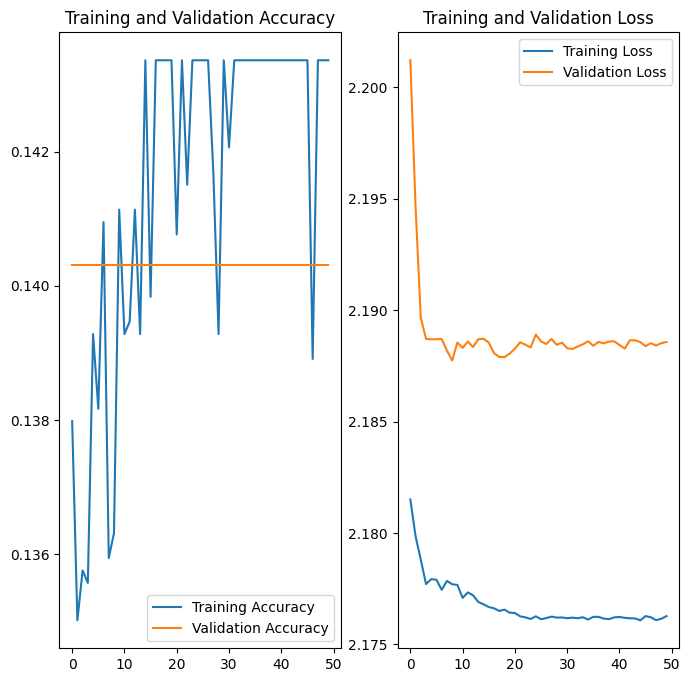

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

No
